<a href="https://colab.research.google.com/github/rezaulcmt/Data_Science_Project_Rezaul/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models
import random

Set random seeds for reproducibility

In [ ]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Device configuration

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Prepare CIFAR-100 data

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize(224),  # Rescale to 224x224 to match ImageNet input size
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

100%|██████████| 169M/169M [00:03<00:00, 51.5MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


Load pretrained ResNet18 model and adjust for CIFAR-100

In [ ]:
print('==> Loading pretrained ResNet18 model..')
net = models.resnet18(pretrained=True)
net.fc = nn.Linear(net.fc.in_features, 100)  # Adjust final layer for CIFAR-100 (100 classes)
net = net.to(device)

==> Loading pretrained ResNet18 model..


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 176MB/s]


Fine-tune the model on CIFAR-100

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9, weight_decay=5e-4)

Fine-tuning loop

In [16]:
print("==> Starting fine-tuning on CIFAR-100..")
for epoch in range(5):  # Adjust number of epochs as needed
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print(f"Epoch {epoch+1}: Train Loss: {train_loss/len(trainloader):.3f} | Train Accuracy: {100.*correct/total:.2f}%")

==> Starting fine-tuning on CIFAR-100..
Epoch 1: Train Loss: 0.672 | Train Accuracy: 80.18%
Epoch 2: Train Loss: 0.407 | Train Accuracy: 88.21%
Epoch 3: Train Loss: 0.226 | Train Accuracy: 94.25%
Epoch 4: Train Loss: 0.114 | Train Accuracy: 97.85%
Epoch 5: Train Loss: 0.055 | Train Accuracy: 99.42%


Define FGSM and PGD attack functions

In [17]:
def fgsm_attack(model, x, y, epsilon):
    x_adv = x.clone().detach().requires_grad_(True).to(device)
    output = model(x_adv)
    loss = criterion(output, y)
    model.zero_grad()
    loss.backward()
    x_adv = x_adv + epsilon * x_adv.grad.sign()
    x_adv = torch.clamp(x_adv, 0, 1)
    return x_adv

def pgd_attack(model, x, y, alpha, epsilon, num_iter):
    x_adv = x.clone().detach().requires_grad_(True).to(device)
    for _ in range(num_iter):
        output = model(x_adv)
        loss = criterion(output, y)
        model.zero_grad()
        loss.backward()
        x_adv = x_adv + alpha * x_adv.grad.sign()
        eta = torch.clamp(x_adv - x, min=-epsilon, max=epsilon)
        x_adv = torch.clamp(x + eta, 0, 1).detach_().requires_grad_(True)
    return x_adv

Carlini-Wagner attack function

In [18]:
def carlini_wagner_attack(model, images, labels, targeted=False, c=1e-4, kappa=0, num_iter=100, learning_rate=0.01):
    images = images.clone().detach().to(device)
    labels = labels.to(device)
    adv_images = images.clone().detach()
    adv_images.requires_grad = True
    optimizer = optim.Adam([adv_images], lr=learning_rate)

    for _ in range(num_iter):
        outputs = model(adv_images)

        if targeted:
            target_class = labels
            f_loss = torch.max((outputs - outputs.gather(1, target_class.view(-1, 1)).squeeze() + kappa).clamp(min=0))
        else:
            correct_class = outputs.gather(1, labels.view(-1, 1)).squeeze()
            f_loss = torch.max((correct_class - outputs + kappa).clamp(min=0), 1).values.mean()

        l2_loss = torch.norm((adv_images - images).view(images.size(0), -1), dim=1).mean()
        loss = l2_loss + c * f_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        adv_images.data = torch.clamp(adv_images.data, 0, 1)

    return adv_images

Test function to evaluate model accuracy on clean or adversarial examples

In [19]:
def test_adversarial(model, attack=None, epsilon=None, alpha=None, num_iter=None):
    correct = 0
    total = 0
    for inputs, targets in testloader:
        inputs, targets = inputs.to(device), targets.to(device)

        if attack == 'FGSM':
            inputs = fgsm_attack(model, inputs, targets, epsilon)
        elif attack == 'PGD':
            inputs = pgd_attack(model, inputs, targets, alpha, epsilon, num_iter)
        elif attack == 'CW':
            inputs = carlini_wagner_attack(model, inputs, targets, targeted=False, num_iter=100, learning_rate=0.01)

        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    acc = 100 * correct / total
    if attack:
        print(f'Accuracy on {attack} adversarial examples: {acc:.2f}%')
    else:
        print(f'Accuracy on clean images: {acc:.2f}%')
    return acc

Calculate base accuracy on clean images

In [20]:
print("==> Evaluating on clean images..")
acc_clean = test_adversarial(net)

==> Evaluating on clean images..
Accuracy on clean images: 80.28%


Parameters for FGSM, PGD, and C&W attacks

In [21]:
epsilon_fgsm = 0.1
epsilon_pgd = 2 / 255
alpha = 2 / 255
num_iter = 5

Testing the pretrained ResNet model on FGSM, PGD, and C&W attacks

In [23]:
acc_fgsm = test_adversarial(net, attack='FGSM', epsilon=epsilon_fgsm)
acc_pgd = test_adversarial(net, attack='PGD', epsilon=epsilon_pgd, alpha=alpha, num_iter=num_iter)
acc_cw = test_adversarial(net, attack='CW')

Accuracy on FGSM adversarial examples: 25.95%
Accuracy on PGD adversarial examples: 9.00%
Accuracy on CW adversarial examples: 24.31%


Plot results

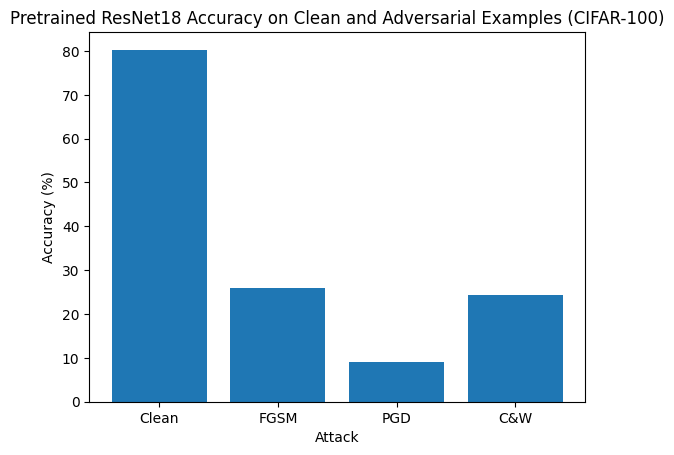

In [24]:
attacks = ['Clean', 'FGSM', 'PGD', 'C&W']
accuracies = [acc_clean, acc_fgsm, acc_pgd, acc_cw]
plt.bar(attacks, accuracies)
plt.xlabel('Attack')
plt.ylabel('Accuracy (%)')
plt.title('Pretrained ResNet18 Accuracy on Clean and Adversarial Examples (CIFAR-100)')
plt.show()